In [4]:
import pandas as pd
from sqlalchemy import create_engine
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import platform
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import statsmodels.api as sm
import ssl
import certifi
from urllib.request import urlopen
import json
from DATA.stock_invest_function import fetch_trade_data_multi_hscode
import seaborn as sns

In [5]:
# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # 윈도우 기본 한글 폰트
elif platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
else:  # Linux (예: Google Colab)
    plt.rc('font', family='NanumGothic')

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [6]:
db_info = {
    'host': '192.168.0.230',
    'port': 3307,
    'user': 'stox7412',
    'password': 'Apt106503!~',
    'database': 'investar'
}

# SQLAlchemy 엔진 생성
engine = create_engine(
    f"mysql+pymysql://{db_info['user']}:{db_info['password']}@{db_info['host']}:{db_info['port']}/{db_info['database']}"
)

# 테이블 이름
table_name = 'target_hs_code'

# 고유한 hs_code 값 추출 쿼리 실행
query = f"SELECT DISTINCT hs_code FROM {table_name}"
unique_hs_codes_df = pd.read_sql(query, con=engine)
hs_codes  = unique_hs_codes_df['hs_code'].unique().tolist()

indicator = 'expDlr'

df_real = fetch_trade_data_multi_hscode(db_info, hs_codes, indicator)


In [7]:
def preprocess_quarterly_growth(df: pd.DataFrame) -> pd.DataFrame:
    """
    월별 데이터를 분기별로 집계하고, 전년 동분기 대비 성장률을 계산하는 함수
    """
    df['quarter'] = df['date'].dt.to_period('Q')
    df_quarterly = (
        df.groupby(['root_hs_code', 'quarter'])['value']
          .sum()
          .reset_index()
    )
    df_quarterly['date'] = df_quarterly['quarter'].dt.to_timestamp(how='end')
    df_quarterly.drop(columns=['quarter'], inplace=True)
    df_quarterly['date'] = pd.to_datetime(df_quarterly['date']).dt.date

    df_quarterly = df_quarterly.sort_values(['root_hs_code', 'date'])
    df_quarterly['yoy_value'] = df_quarterly.groupby('root_hs_code')['value'].shift(4)
    df_quarterly['yoy_growth'] = (
        (df_quarterly['value'] - df_quarterly['yoy_value']) / df_quarterly['yoy_value']
    ) * 100

    return df_quarterly


def create_yoy_growth_pivot(df_quarterly: pd.DataFrame,
                             start_date: str = None,
                             end_date: str = None) -> pd.DataFrame:
    """
    전년 동분기 대비 증가율을 pivot 형태로 변환하고 분석기간을 설정할 수 있는 함수
    
    Parameters:
    - df_quarterly (DataFrame): 'root_hs_code', 'date', 'yoy_growth' 포함된 데이터
    - start_date (str or None): 분석 시작일 (예: '2015-01-01')
    - end_date (str or None): 분석 종료일 (예: '2023-12-31')

    Returns:
    - pivot_df (DataFrame): 행: date, 열: root_hs_code, 값: yoy_growth
    """
    pivot_df = df_quarterly.pivot(
        index='date',
        columns='root_hs_code',
        values='yoy_growth'
    ).sort_index()

    pivot_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    pivot_df.index = pd.to_datetime(pivot_df.index)

    if start_date:
        pivot_df = pivot_df[pivot_df.index >= pd.to_datetime(start_date)]
    if end_date:
        pivot_df = pivot_df[pivot_df.index <= pd.to_datetime(end_date)]

    return pivot_df


In [8]:
df_quarterly = preprocess_quarterly_growth(df_real)
quarterly_growth_data = create_yoy_growth_pivot(df_quarterly, start_date= '2008-01', end_date='2025-03')

In [9]:
quarterly_growth_data

root_hs_code,121120,121221,151550,151590,170199,190230,190590,200599,200830,200899,...,903149,903180,903190,903289,940130,940199,940330,940540,950300,970191
date,,,,,,,,,,,,,,,,,,,,,
2008-03-31,90.336099,NaN,16.777894,45.319785,-2.089371,19.901271,19.931377,6.957235,-2.343829,-33.535181,...,138.220984,41.192713,31.732529,80.695522,-47.403236,NaN,-9.986462,174.910924,-15.512682,NaN
2008-06-30,20.815636,NaN,112.829026,100.885760,-16.864182,18.872828,19.753492,15.020885,0.999482,30.527594,...,41.938920,36.543978,42.186509,-23.715247,53.141968,NaN,-18.646441,343.067034,-9.585525,NaN
2008-09-30,-41.073208,NaN,55.462621,33.656911,-10.472852,23.743338,7.138119,17.262148,37.208676,-15.271706,...,40.219235,-11.991021,36.523453,11.187714,48.790449,NaN,-47.857885,349.811942,-8.644475,NaN
2008-12-31,3.144400,NaN,-39.795990,144.057451,-0.056993,-8.459365,-3.608346,13.263258,6.142602,-23.742025,...,-30.760604,-8.942473,-9.105317,-38.998382,21.072238,NaN,5.974349,182.631540,-14.960084,NaN
2009-03-31,1.288444,NaN,115.673004,-9.411258,-21.750020,-5.503269,-7.306533,4.732786,-24.087312,-13.081807,...,-69.204685,-10.281097,-40.196447,-37.350827,-21.135143,NaN,-46.536388,-47.573484,-18.793910,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,5.035949,21.451449,-3.635093,-8.826610,20.303902,27.255952,20.929892,11.717477,-9.394534,37.554516,...,-13.899575,25.187896,17.375068,45.880632,NaN,0.907928,15.475628,NaN,15.779052,-23.900927
2024-03-31,-38.869973,20.516295,-2.935003,-6.483635,33.624345,28.998818,3.954067,5.975202,-18.734050,16.652831,...,-28.634298,1.866472,26.750878,16.182839,NaN,4.233538,64.329712,NaN,0.568879,-29.012535
2024-06-30,40.483316,65.488901,44.078181,50.584872,-3.949636,32.371678,3.630900,1.988888,-16.947354,18.330731,...,19.021802,-2.056160,10.357521,14.610146,NaN,2.455197,56.423311,NaN,12.462183,68.391967


In [10]:
from sqlalchemy import create_engine  # ✅ 이 줄이 빠졌습니다

db_info = {
    'host': '192.168.0.230',
    'port': 3307,
    'user': 'stox7412',
    'password': 'Apt106503!~',
    'database': 'investar'
}

# SQLAlchemy 엔진 생성
engine = create_engine(
    f"mysql+pymysql://{db_info['user']}:{db_info['password']}@{db_info['host']}:{db_info['port']}/{db_info['database']}"
)

# 데이터 불러오기
query = "SELECT * FROM US_fundq"
df_us_fundq = pd.read_sql(query, con=engine)

# 결과 확인
# print("✅ 데이터 로드 완료")
# print(df_us_fundq.head())  # 상위 5개 행만 출력

✅ 데이터 로드 완료
   permno       edate       date  dlret  dlretx  exchcd  naics   permco  \
0   87432  2000-01-31 2000-01-31    NaN     NaN     1.0    NaN  36364.0   
1   87432  2000-02-29 2000-02-29    NaN     NaN     1.0    NaN  36364.0   
2   87432  2000-03-31 2000-03-31    NaN     NaN     1.0    NaN  36364.0   
3   87432  2000-04-30 2000-04-30    NaN     NaN     1.0    NaN  36364.0   
4   87432  2000-05-31 2000-05-31    NaN     NaN     1.0    NaN  36364.0   

        prc       ret  ...   xrdq  xsgaq  capxy  chechy dlcchy  dltisy  \
0   66.1875 -0.143897  ...  259.0  792.0   91.0  1368.0  111.0     0.0   
1  103.8750  0.569405  ...  259.0  792.0   91.0  1368.0  111.0     0.0   
2  104.0000  0.001203  ...  259.0  792.0   91.0  1368.0  111.0     0.0   
3   88.6250 -0.147837  ...  263.0  889.0  222.0   978.0   98.0     0.0   
4   73.6250 -0.169252  ...  263.0  889.0  222.0   978.0   98.0     0.0   

   fincfy  oancfy  prstkcy   sstky  
0  1192.0   384.0      0.0  2068.0  
1  1192.0   384.0 

In [20]:
# 1. 'saleq' 결측 제거 및 필요한 컬럼만 추출
df = df_us_fundq[['date', 'tic', 'saleq']].dropna(subset=['saleq'])

# 2. 중복 방지: (date, tic) 별로 집계 (예: 평균)
df_grouped = df.groupby(['date', 'tic'], as_index=False)['saleq'].mean()

# 3. Pivot: index=date, columns=tic, values=saleq
pivot_df = df_grouped.pivot(index='date', columns='tic', values='saleq')

# 4. 분기별 집계 (예: 합계)
quarterly_sales = pivot_df.resample('QE').sum()

# 5. 전년 대비 증가율 계산 (%)
quarterly_sales_yoy = quarterly_sales.pct_change(periods=4) * 100

# ✅ inf 값 NaN 처리
quarterly_sales_yoy.replace([np.inf, -np.inf], np.nan, inplace=True)


In [21]:
start_date = '2008-01'
end_date = '2025-03'
quarterly_sales_resize = quarterly_sales_yoy.loc[start_date : end_date] 

# 2. NaN이 포함된 열 제거
sales_growth_df = quarterly_sales_resize.dropna(axis=1, how='any')

In [23]:
# 1. 공통된 날짜 인덱스 추출
common_dates = quarterly_growth_data.index.intersection(sales_growth_df.index)

# 2. 공통 인덱스 기준으로 정렬 및 정제
qdata = quarterly_growth_data.loc[common_dates]
sdata = sales_growth_df.loc[common_dates]

# 3. 두 데이터프레임을 좌우로 concat
merged_df = pd.concat([qdata, sdata], axis=1)

# 4. 상관관계 행렬 계산
corr_matrix = merged_df.corr()

# 5. quarterly_growth_data (왼쪽 블록) vs sales_growth_df (오른쪽 블록) 간의 상관만 추출
q_cols = quarterly_growth_data.columns
s_cols = sales_growth_df.columns

inter_corr = corr_matrix.loc[q_cols, s_cols]

In [43]:
def get_high_corr_tickers(corr_df, hs_code, threshold=0.5):
    """
    특정 HS 코드에 대해 상관계수가 일정 기준 이상인 티커만 추출

    Parameters:
        corr_df (pd.DataFrame): HS 코드 vs 기업 티커 상관행렬 (index=HS, columns=ticker)
        hs_code (str or int): 조회할 HS 코드
        threshold (float): 상관계수 기준값 (기본값: 0.5)

    Returns:
        pd.Series: 상관계수가 threshold 이상인 티커와 해당 상관계수
    """
    if hs_code not in corr_df.index:
        raise ValueError(f"❌ '{hs_code}' 는 상관행렬에 존재하지 않습니다.")

    row = corr_df.loc[hs_code]
    filtered = row[row >= threshold].sort_values(ascending=False)
    return filtered

def get_high_corr_hscodes(corr_df, ticker, top_n=10, threshold=0.5):
    """
    특정 기업 티커와 상관계수가 높은 HS 코드 상위 N개를 반환

    Parameters:
        corr_df (pd.DataFrame): HS 코드 vs 기업 티커 상관행렬
        ticker (str): 기업 티커 (ex. 'MU')
        top_n (int): 상위 몇 개를 추출할지 (기본값: 10)
        threshold (float): 최소 상관계수 기준 (기본값: 0.5)

    Returns:
        pd.DataFrame: HS 코드와 상관계수가 포함된 결과 DataFrame
    """
    if ticker not in corr_df.columns:
        raise ValueError(f"❌ '{ticker}' 는 상관행렬에 존재하지 않습니다.")

    col = corr_df[ticker]
    filtered = col[col >= threshold].sort_values(ascending=False).head(top_n)

    return filtered.reset_index().rename(columns={ticker: 'Correlation', 'index': 'HS_code'})

In [28]:
# CSV로 저장
# inter_corr.to_csv(r"C:\Users\82108\OneDrive\바탕 화면\investment\investment_strategy\미국시장\분석\hscode_ticker_correlations.csv", index=True, encoding='utf-8-sig')

   HS_code Ticker  Correlation
0   854143    FTK     0.995428
1   854143    GPK     0.992923
2   681511   PAYX     0.992390
3   854143   CROX     0.991532
4   854143   JACK     0.989613
5   854143   MRTN     0.989565
6   854143    AZZ     0.986765
7   854143    WBD     0.986580
8   854143    ATI     0.985793
9   851419   ROST     0.985349
10  852491   LFCR     0.985341
11  220299  AXDXQ     0.985325
12  854143    AAL     0.985199
13  845521   OMEX     0.984370
14  854143    FDS     0.983048
15  852589   LCUT     0.982318
16  854143     IT     0.982268
17  711021    WBD     0.981134
18  854143    UAL     0.980100
19  854143   BOOM     0.979983


In [30]:
# 예: HS 코드 '854232'와 상관계수 0.5 이상인 티커 찾기
high_corr_tickers = get_high_corr_tickers(inter_corr, hs_code='854232', threshold=0.5)

print(high_corr_tickers)

# # CSV 저장도 가능
# high_corr_tickers.to_csv("high_corr_tickers_854232.csv", header=True, encoding='utf-8-sig')

tic
MU      0.841335
WGO     0.655041
KLIC    0.648438
UCTT    0.626985
LRCX    0.620134
CAAS    0.570361
LPX     0.556255
THO     0.554609
WSO     0.551095
INTT    0.549412
AMAT    0.548747
AXTI    0.538857
TRT     0.537747
LCII    0.530097
MKSI    0.527032
POWI    0.525949
TXN     0.519767
OSK     0.512219
FORM    0.509649
Name: 854232, dtype: float64


In [47]:
# 예: 'MU' 티커와 상관계수 0.5 이상인 HS 코드 상위 10개
top_hscodes_for_company = get_high_corr_hscodes(inter_corr, ticker='CAT', top_n=20, threshold=0.5)
top_hscodes_for_company 

,root_hs_code,Correlation
0,681511,0.964777
1,620240,0.863873
2,845811,0.831937
3,820740,0.762008
4,730791,0.761787
5,842720,0.755572
6,854143,0.741682
7,842710,0.706556
8,820750,0.699520
9,846290,0.691456


In [40]:
high_corr_tickers[high_corr_tickers.index == 'DE']

Series([], Name: 842952, dtype: float64)

In [39]:
# 분기 정보 추가
df_real['quarter'] = df_real['date'].dt.to_period('Q')

# 그룹별로 분기별 합산
df_quarterly = (
    df_real
    .groupby(['root_hs_code', 'quarter'])['value']
    .sum()
    .reset_index()
)

# 👉 분기 월말로 변환 (예: 2007Q1 → 2007-03-31)
df_quarterly['date'] = df_quarterly['quarter'].dt.to_timestamp(how='end')

# 👉 'quarter' 컬럼 제거
df_quarterly.drop(columns=['quarter'], inplace=True)

# 1단계: 문자열로 직접 변환하려면 to_datetime 이후에 바로 strftime
df_quarterly['date'] = pd.to_datetime(df_quarterly['date']).dt.strftime('%Y-%m-%d')

In [40]:
def create_yoy_growth_pivot(df_quarterly, start_date=None, end_date=None):
    """
    전년 동분기 대비 증가율을 pivot 형태로 변환하고 분석기간을 설정할 수 있는 함수

    Parameters:
    - df_quarterly (DataFrame): 'root_hs_code', 'date', 'yoy_growth' 포함된 데이터
    - start_date (str or None): 분석 시작일 (예: '2015-01-01')
    - end_date (str or None): 분석 종료일 (예: '2023-12-31')

    Returns:
    - pivot_df (DataFrame): 행: date, 열: root_hs_code, 값: yoy_growth
    """
    # Pivot
    pivot_df = df_quarterly.pivot(
        index='date',
        columns='root_hs_code',
        values='yoy_growth'
    ).sort_index()

    # inf 값 NaN 처리
    pivot_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 분석 기간 슬라이싱 (날짜가 문자열이면 datetime으로 변환)
    pivot_df.index = pd.to_datetime(pivot_df.index)

    if start_date:
        pivot_df = pivot_df[pivot_df.index >= pd.to_datetime(start_date)]
    if end_date:
        pivot_df = pivot_df[pivot_df.index <= pd.to_datetime(end_date)]

    return pivot_df


# 전년 동분기 값 (4개 분기 전 값) 계산
df_quarterly['yoy_value'] = (
    df_quarterly
    .sort_values(['root_hs_code', 'date'])
    .groupby('root_hs_code')['value']
    .shift(4)
)

quarterly_pivot = create_yoy_growth_pivot(df_quarterly, start_date='2008-03', end_date='2025-03')


KeyError: 'yoy_growth'

In [ ]:
quarterly_pivot[['854232']].tail(12)

In [3]:
def load_forecast_by_hscode(db_info, root_hs_code, table_name='trade_forecast_by_month'):
    """
    특정 root_hs_code에 해당하는 예측 데이터를 데이터베이스에서 불러오는 함수

    Parameters:
    - db_info (dict): DB 접속 정보 (host, port, user, password, database)
    - root_hs_code (str or int): 조회할 HS 코드
    - table_name (str): 테이블 이름 (기본값: 'trade_forecast_by_month')

    Returns:
    - pd.DataFrame: 조회된 데이터프레임
    """
    try:
        # ✅ DB 엔진 생성
        engine = create_engine(
            f"mysql+pymysql://{db_info['user']}:{db_info['password']}@{db_info['host']}:{db_info['port']}/{db_info['database']}"
        )

        # ✅ SQL 쿼리 작성 및 실행
        query = f"""
            SELECT *
            FROM {table_name}
            WHERE root_hs_code = '{root_hs_code}'
            ORDER BY period
        """
        df = pd.read_sql(query, con=engine)

        print(f"✅ root_hs_code={root_hs_code}에 해당하는 {len(df)}개 행을 불러왔습니다.")
        return df
    
    except Exception as e:
        print(f"❌ 데이터 불러오기 실패: {e}")
        return pd.DataFrame()

In [27]:
db_info = {
    'host' : '192.168.0.230',
    'port' : 3307,
    'user' : 'stox7412',
    'password' : 'Apt106503!~',
    'database' : 'investar'
}

target_export_df = load_forecast_by_hscode(db_info, '854232')
target_export_df = target_export_df.drop_duplicates(subset=['period'])

# period를 datetime 형식으로 변환 (이미 되어 있다면 생략 가능)
target_export_df['period'] = pd.to_datetime(target_export_df['period'])

# 분기 정보 추출
target_export_df['quarter'] = target_export_df['period'].dt.to_period('Q')

# 분기별 합계 계산
quarterly_sum_df = target_export_df.groupby('quarter')['expDlr_forecast_12m'].sum().reset_index()

# datetime으로 변환 (원하는 경우)
quarterly_sum_df['quarter'] = quarterly_sum_df['quarter'].dt.to_timestamp()

quarterly_sum_df['export_qoq_change'] = quarterly_sum_df['expDlr_forecast_12m'].pct_change(periods=1)
quarterly_sum_df['export_yoy_change'] = quarterly_sum_df['expDlr_forecast_12m'].pct_change(periods=4)
# quarterly_sum_df.rename(columns={'quarter' : 'date_month'}, inplace=True)

# ✅ 각 분기의 말일 날짜를 "year_month"라는 새로운 컬럼으로 추가
quarterly_sum_df['date_month'] = quarterly_sum_df['quarter'] + pd.offsets.QuarterEnd(0)

# 결과 확인
print(quarterly_sum_df)

✅ root_hs_code=854232에 해당하는 904개 행을 불러왔습니다.
      quarter  expDlr_forecast_12m  export_qoq_change  export_yoy_change  \
0  2007-01-01         0.000000e+00                NaN                NaN   
1  2007-04-01         0.000000e+00                NaN                NaN   
2  2007-07-01         0.000000e+00                NaN                NaN   
3  2007-10-01         0.000000e+00                NaN                NaN   
4  2008-01-01         3.383904e+09                inf                inf   
..        ...                  ...                ...                ...   
73 2025-04-01         2.002932e+10           0.237416           0.133763   
74 2025-07-01         2.102303e+10           0.049613           0.120286   
75 2025-10-01         2.028235e+10          -0.035232           0.008648   
76 2026-01-01         1.699342e+10          -0.162157           0.049857   
77 2026-04-01         5.685559e+09          -0.665426          -0.716138   

   date_month  
0  2007-03-31  
1  2007-06-

In [61]:
# quarterly_sum_df.to_csv('quarterly_sum_df.csv')

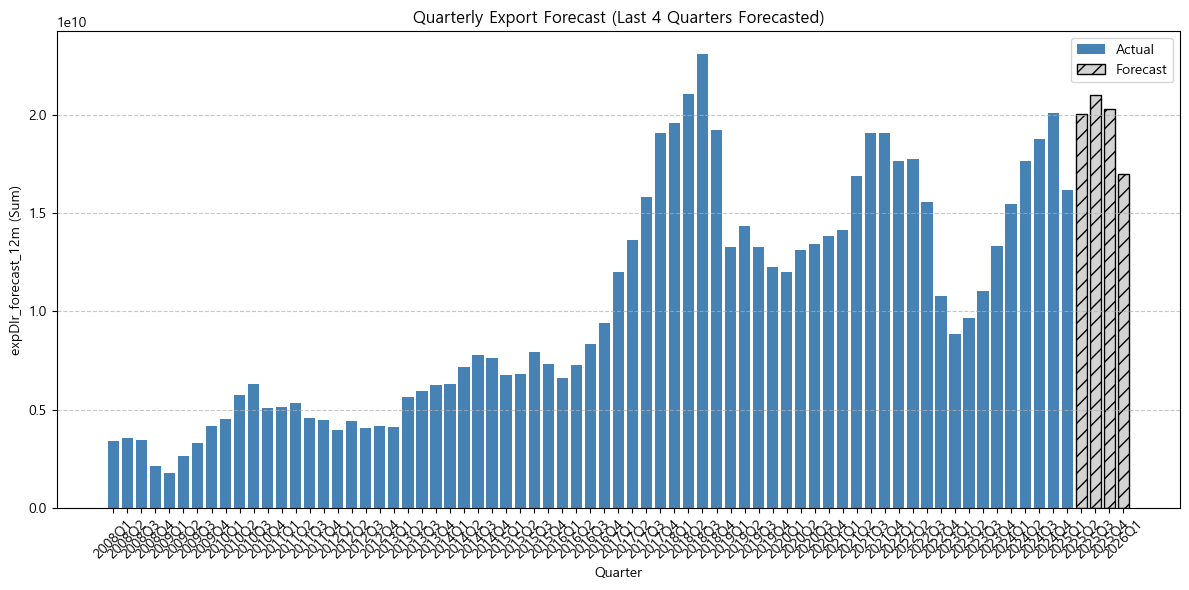

In [24]:
# 날짜 필터 범위 설정
start_date = '2008-01-01'
end_date = '2026-01-01'

# 기간 필터링
mask = (quarterly_sum_df['quarter'] >= start_date) & (quarterly_sum_df['quarter'] <= end_date)
filtered_df = quarterly_sum_df[mask].copy()

# 정렬 보장
filtered_df = filtered_df.sort_values('quarter').reset_index(drop=True)

# 마지막 4개 분기를 forecast로 지정, 나머지는 actual
filtered_df['type'] = 'actual'
filtered_df.loc[filtered_df.index[-4:], 'type'] = 'forecast'

# x축 표시용 문자열 생성 (ex: 2024Q2)
filtered_df['quarter_str'] = filtered_df['quarter'].dt.to_period('Q').astype(str)

# 시각화
plt.figure(figsize=(12, 6))

for i, row in filtered_df.iterrows():
    if row['type'] == 'actual':
        plt.bar(row['quarter_str'], row['expDlr_forecast_12m'],
                label='Actual' if i == 0 else "", color='steelblue')
    else:
        plt.bar(row['quarter_str'], row['expDlr_forecast_12m'],
                label='Forecast' if i == len(filtered_df) - 4 else "",  # 첫 forecast 막대만 범례에 포함
                color='lightgray', edgecolor='black', hatch='//')

# 포맷 설정
plt.xlabel('Quarter')
plt.ylabel('expDlr_forecast_12m (Sum)')
plt.title('Quarterly Export Forecast (Last 4 Quarters Forecasted)')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
# JSON 데이터를 불러오는 함수
def get_jsonparsed_data(url):
    context = ssl.create_default_context(cafile=certifi.where())  # SSLContext 생성
    with urlopen(url, context=context) as response:  # SSLContext 사용
        data = response.read().decode("utf-8")
        return json.loads(data)

compustat_is = ['report_date', 'ticker', 'period', 'sale', 'cogs', 'gp', 'xrd', 'xsga', 'idit', 'xint', 'dp', 'ebitda', 'xopr', 'opiti', 'opir', 'pi', 'pir', 'txt', 'ni', 'nir', 'eps', 'epsdi', 'shrout', 'shroutdi']
dates_list = pd.date_range('2004-01-31', '2025-04-30', freq='M')

is_list = []
error_list = []

# tqdm을 사용하여 진행 상황을 시각화
ticker = 'AMAT'
tic_list = [ticker]

for tick in tqdm(tic_list, desc="Processing Tickers"):

    print(tick)

    try:
        url = ("https://financialmodelingprep.com/api/v3/income-statement/{}?period=quarter&apikey=hT0gAk87j9xZx4PlBApvBqfVL5IahvgV".format(tick))
        fs_raw = get_jsonparsed_data(url)
        temp_df = pd.DataFrame(fs_raw)
        print(temp_df)

        is_df = temp_df[['date', 'symbol','period', 'revenue', 'costOfRevenue', 'grossProfit','researchAndDevelopmentExpenses', 'sellingGeneralAndAdministrativeExpenses',
                        'interestIncome', 'interestExpense', 'depreciationAndAmortization', 'ebitda', 'operatingExpenses', 'operatingIncome',
                        'operatingIncomeRatio', 'incomeBeforeTax', 'incomeBeforeTaxRatio','incomeTaxExpense', 'netIncome',
                        'netIncomeRatio', 'eps', 'epsdiluted', 'weightedAverageShsOut','weightedAverageShsOutDil']]

        is_df.columns = compustat_is
    except:error_list.append(tick)

    is_df_sorted = is_df.sort_values(by='report_date')
    is_df_sorted['report_date'] = pd.to_datetime(is_df_sorted['report_date'])
    # 'YYYY-MM' 형태로 변환
    is_df_sorted['date_month'] = is_df_sorted['report_date'].dt.to_period('M').astype(str)
    # 'YYYY-MM'을 월말 날짜로 변환
    is_df_sorted['date'] = pd.to_datetime(is_df_sorted['date_month']) + pd.offsets.MonthEnd(0)
    # 데이터프레임 생성
    date_df = pd.DataFrame(dates_list, columns=['date'])
    temp_is = pd.merge(date_df, is_df_sorted, on=['date'], how='left').ffill()
    is_list.append(temp_is)

is_df = pd.concat(is_list)

C:\Users\82108\AppData\Local\Temp\ipykernel_20860\1827583606.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates_list = pd.date_range('2004-01-31', '2025-04-30', freq='M')
Processing Tickers:   0%|          | 0/1 [00:00<?, ?it/s]

AMAT


Processing Tickers: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

           date symbol reportedCurrency         cik fillingDate  \
0    2025-04-27   AMAT              USD  0000006951  2025-05-22   
1    2025-01-26   AMAT              USD  0000006951  2025-02-20   
2    2024-10-27   AMAT              USD  0000006951  2024-12-13   
3    2024-07-28   AMAT              USD  0000006951  2024-08-22   
4    2024-04-28   AMAT              USD  0000006951  2024-05-23   
..          ...    ...              ...         ...         ...   
154  1986-10-31   AMAT              USD  0000006951  1986-10-31   
155  1986-07-31   AMAT              USD  0000006951  1986-07-31   
156  1986-04-30   AMAT              USD  0000006951  1986-04-30   
157  1986-01-31   AMAT              USD  0000006951  1986-01-31   
158  1985-10-31   AMAT              USD  0000006951  1985-10-31   

            acceptedDate calendarYear period     revenue  costOfRevenue  ...  \
0    2025-05-22 16:02:01         2025     Q2  7100000000     3615000000  ...   
1    2025-02-20 16:02:43         20

In [50]:
target_data = is_df[['date', 'date_month', 'ticker', 'period',  'sale', 'gp', 'ni']].copy()
target_data_drop = target_data.drop_duplicates(subset=['date_month', 'period'], keep='last').copy()

# 날짜 정렬을 위한 변환
target_data_drop['date_month'] = pd.to_datetime(target_data_drop['date_month'])

# 정렬
target_data_drop = target_data_drop.sort_values(['ticker', 'date_month']).reset_index(drop=True)

# YoY 및 QoQ 계산
for col in ['sale', 'gp', 'ni']:
    qoq_col = f'{col}_qoq'
    yoy_col = f'{col}_yoy'
    
    target_data_drop[qoq_col] = target_data_drop.groupby('ticker')[col].transform(lambda x: x.pct_change(periods=1))
    target_data_drop[yoy_col] = target_data_drop.groupby('ticker')[col].transform(lambda x: x.pct_change(periods=4))
    
# 1. 날짜 형식 맞추기
target_data_drop['date_month'] = pd.to_datetime(target_data_drop['date_month'])
quarterly_sum_df['date_month'] = pd.to_datetime(quarterly_sum_df['date_month'])

# 2. NaT (null 날짜) 제거
target_data_drop = target_data_drop[target_data_drop['date_month'].notna()]
quarterly_sum_df = quarterly_sum_df[quarterly_sum_df['date_month'].notna()]

# 3. 날짜 정렬
target_data_drop = target_data_drop.sort_values('date_month')
quarterly_sum_df = quarterly_sum_df.sort_values('date_month')

# 4. 병합 (가장 가까운 날짜 기준)
regression_table = pd.merge_asof(
    target_data_drop,
    quarterly_sum_df[['date_month', 'export_qoq_change', 'export_yoy_change']],
    on='date_month',
    direction='nearest'  # 또는 'backward', 'forward'로 조절 가능
)


In [62]:
quarterly_sum_df.tail(12)

,quarter,expDlr_forecast_12m,export_qoq_change,export_yoy_change,date_month
66,2023-07-01,1.104453e+10,0.141117,-0.290891,2023-09-30
67,2023-10-01,1.332626e+10,0.206594,0.233777,2023-12-31
68,2024-01-01,1.547925e+10,0.161560,0.750191,2024-03-31
69,2024-04-01,1.766623e+10,0.141284,0.825268,2024-06-30
70,2024-07-01,1.876577e+10,0.062240,0.699102,2024-09-30
71,2024-10-01,2.010845e+10,0.071549,0.508934,2024-12-31
72,2025-01-01,1.618641e+10,-0.195044,0.045684,2025-03-31
73,2025-04-01,2.002932e+10,0.237416,0.133763,2025-06-30
74,2025-07-01,2.102303e+10,0.049613,0.120286,2025-09-30
75,2025-10-01,2.028235e+10,-0.035232,0.008648,2025-12-31


C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
C:\Users\82108\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


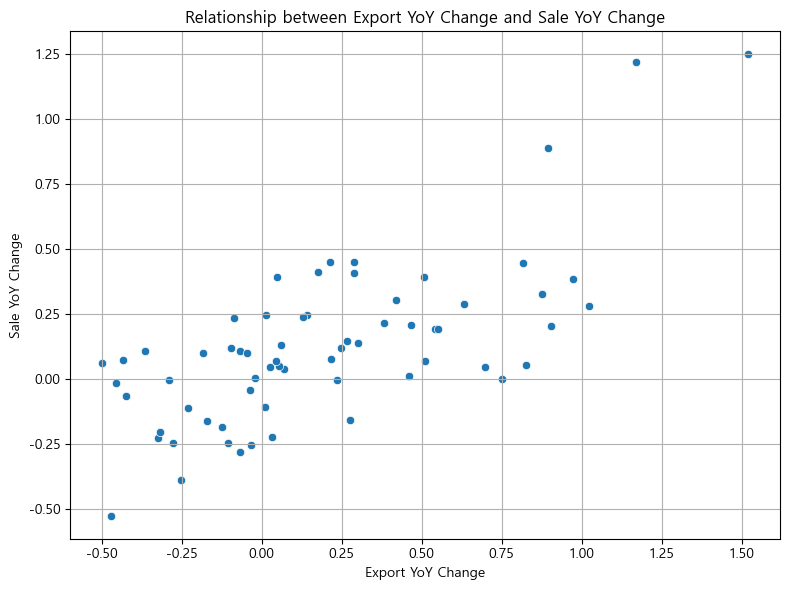

In [52]:
import seaborn as sns

# NaN 제거 (두 변수 모두 값이 있어야 함)
plot_df = regression_table[['export_yoy_change', 'sale_yoy']].dropna()

# 산점도 그리기
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='export_yoy_change', y='sale_yoy')

# 회귀선 추가 (선택)
sns.regplot(data=plot_df, x='export_yoy_change', y='sale_yoy', scatter=False, color='red')

# 라벨 및 제목
plt.xlabel('Export YoY Change')
plt.ylabel('Sale YoY Change')
plt.title('Relationship between Export YoY Change and Sale YoY Change')
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
# 1. 대상 변수 목록
cols = [
    'sale_qoq', 'sale_yoy',
    'gp_qoq', 'gp_yoy',
    'ni_qoq', 'ni_yoy',
    'export_qoq_change', 'export_yoy_change'
]

# 2. 결측치 제거
corr_df = regression_table[cols].dropna()

# 3. 상관계수 계산
corr_matrix = corr_df.corr()

In [60]:
corr_matrix 

,sale_qoq,sale_yoy,gp_qoq,gp_yoy,ni_qoq,ni_yoy,export_qoq_change,export_yoy_change
sale_qoq,1.000000,0.443248,0.818052,0.415427,0.098186,0.033588,0.443748,0.322000
sale_yoy,0.443248,1.000000,0.203223,0.855936,0.387302,0.173275,0.272004,0.701876
gp_qoq,0.818052,0.203223,1.000000,0.219735,-0.009686,0.039177,0.511397,0.136260
gp_yoy,0.415427,0.855936,0.219735,1.000000,0.318984,0.006685,0.205279,0.642424
ni_qoq,0.098186,0.387302,-0.009686,0.318984,1.000000,0.218261,-0.080601,0.207866
ni_yoy,0.033588,0.173275,0.039177,0.006685,0.218261,1.000000,-0.084077,-0.021179
export_qoq_change,0.443748,0.272004,0.511397,0.205279,-0.080601,-0.084077,1.000000,0.471765
export_yoy_change,0.322000,0.701876,0.136260,0.642424,0.207866,-0.021179,0.471765,1.000000


In [54]:
# 1. 변수 추출 후 NaN, inf 제거
reg_df = regression_table[['export_yoy_change', 'sale_yoy']].copy()
reg_df = reg_df.replace([np.inf, -np.inf], np.nan).dropna()

# 2. 독립변수(X), 종속변수(Y) 정의
X = reg_df['export_yoy_change']
Y = reg_df['sale_yoy']

# 3. 상수항 추가 (절편 포함)
X = sm.add_constant(X)

# 4. 회귀모델 적합
model = sm.OLS(Y, X).fit()

# 5. 회귀 요약 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               sale_yoy   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     61.17
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           7.33e-11
Time:                        21:39:50   Log-Likelihood:                 6.4547
No. Observations:                  65   AIC:                            -8.909
Df Residuals:                      63   BIC:                            -4.561
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0300      0.03

In [55]:
target_data_drop.tail()

,date,date_month,ticker,period,sale,gp,ni,sale_qoq,sale_yoy,gp_qoq,gp_yoy,ni_qoq,ni_yoy
81,2024-06-30,2024-04-01,AMAT,Q2,6.646000e+09,3.153000e+09,1.722000e+09,-0.009095,0.002413,-0.015918,0.019069,-0.147103,0.093333
82,2024-09-30,2024-07-01,AMAT,Q3,6.778000e+09,3.205000e+09,1.705000e+09,0.019862,0.054942,0.016492,0.076949,-0.009872,0.092949
83,2024-12-31,2024-10-01,AMAT,Q4,7.045000e+09,3.335000e+09,1.731000e+09,0.039392,0.047895,0.040562,0.052382,0.015249,-0.136228
84,2025-03-31,2025-01-01,AMAT,Q1,7.166000e+09,3.496000e+09,1.185000e+09,0.017175,0.068436,0.048276,0.091136,-0.315425,-0.413076
85,2025-04-30,2025-04-01,AMAT,Q2,7.100000e+09,3.485000e+09,2.137000e+09,-0.009210,0.068312,-0.003146,0.105297,0.803376,0.240999


In [58]:
# 1. 가장 최근 매출 (2024-11-01 기준)
last_known_sale = 7.100000e+09

# 2. 회귀계수
intercept = 0.0300
slope = 0.4880

# 3. export_yoy_change 향후 4개 분기 가정값
export_yoy_forecast = {
    '2025-06-30': 0.134,
    '2025-09-30': 0.12,
    '2025-12-31': 0.01,
    '2026-03-31': 0.05
}

# 4. 예측 수행
forecast_result = []
current_sale = last_known_sale

for date_str, export_yoy in export_yoy_forecast.items():
    predicted_sale_yoy = intercept + slope * export_yoy
    predicted_sale = current_sale * (1 + predicted_sale_yoy)
    forecast_result.append({
        'date_month': date_str,
        'export_yoy_change': export_yoy,
        'predicted_sale_yoy': predicted_sale_yoy,
        'predicted_sale': predicted_sale
    })
    current_sale = predicted_sale  # 다음 분기의 기준 매출로 업데이트

# 5. 결과 DataFrame으로 보기
forecast_df = pd.DataFrame(forecast_result)
forecast_df['date_month'] = pd.to_datetime(forecast_df['date_month'])
forecast_df

,date_month,export_yoy_change,predicted_sale_yoy,predicted_sale
0,2025-06-30,0.134,0.095392,7.777283e+09
1,2025-09-30,0.120,0.088560,8.466039e+09
2,2025-12-31,0.010,0.034880,8.761335e+09
3,2026-03-31,0.050,0.054400,9.237951e+09
